## Copied from Neelam
All content until the hbar was from him

In [ ]:
!pip install -q pymc
!pip install -q diffrax
!pip install -q namedtupled

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.7/141.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 8.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import pytensor
import pytensor.tensor as pt
from pytensor.graph import Apply, Op
from pytensor.link.jax.dispatch import jax_funcify

import jax
import jax.numpy as jnp
from scipy.stats import differential_entropy as entr

import pymc as pm
import pymc.sampling.jax

seed = 8675309
np.random.seed(seed)

In [ ]:
import diffrax
import jax
import jax.numpy as jnp

# FYI

This fish population sim. is fairly barebones. It's pretty much exclusively based on the information Rafael provided on modelling fish dynamics which ended up being quite useful (link - https://onlinelibrary.wiley.com/doi/pdf/10.1002/sdr.392) and incorporates elements of probabilistic programming (i.e. JAX & Diffrax).


The DE that models the simulation is given by:

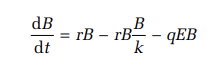

(see pg. 4 of link for description)

Where,

  B -  biomass of the fish (which I simply treated as # of fish)

  r - growth rate

  k - maximum capacity of fish the environment can hold

  q - number of fisherman boats

  E - effeciency of the fisherman boats

(for simplicity I lumped q & E into a single term)

# Deterministic Simulation

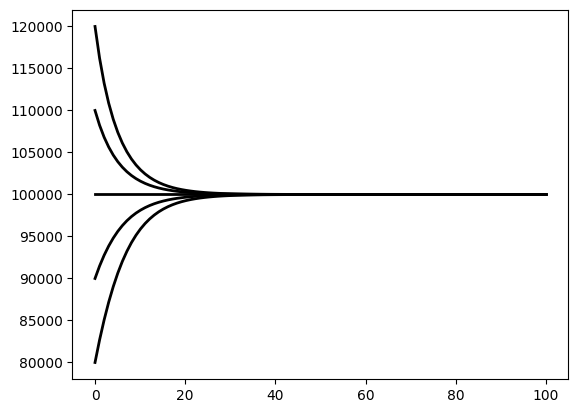

In [ ]:
import diffrax
import jax
import jax.numpy as jnp

# Define the DE
def fish_population_DE(t, B, args):
    r, K, q = args
    dB_dt = r * B - B**2 *(r/ K )- q * B
    return dB_dt

# Create the ODE term
term = diffrax.ODETerm(fish_population_DE)

# Choose a diffrax solver to solve DE
solver = diffrax.Dopri5()
t_end = 100
num_points = 100

# Define the points in time where you want to save the solution
saveat = diffrax.SaveAt(ts=jnp.linspace(0., t_end, num_points))
# set the tolerated error between numerical estimation and true value
stepsize_controller = diffrax.PIDController(rtol=1e-5, atol=1e-5)

# Wrap the ODE solver in a JAX function
def sol_op_jax(B0, r, K, q):
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0=0,
        t1=t_end,
        dt0=0.1,
        y0=B0,
        args=(r, K, q),
        saveat=saveat,
        stepsize_controller=stepsize_controller,
    )

    return sol.ys

# don't actually know what this does, apparently improves computation performance
jitted_sol_op_jax = jax.jit(sol_op_jax)

# Deterministic example using variables mostly copied from the ref'd fish dynamics paper
B0 = jnp.array([80000, 90000, 100000, 110000, 120000])  # Initial biomass
r = 0.2  # Growth rate
K = (100000/0.875)
q = 0.025  # Fishing effeciency
sigma_eps = 100  # std-dev of epsilon

# Solve the ODE
sol_ys = jitted_sol_op_jax(B0, r, K, q,)

time_points = jnp.linspace(0., t_end, num_points)
#Plot the 5 sample simulations
plt.plot(time_points, sol_ys, label='Deterministic Solution', color='black', linewidth=2)


This illustrates 5 simulations of possible fish population trajectories with different starting populations, all other variables kept the same. The important thing is that the steady state is given by,

Bss = K/r(r-q) --> r>q

So, after more research is done to figure out what reasonable estimations for B, K, r, and q would be, we can play around with the numbers to find some optimal Bss.

# Probabilistic Simulation

PS: a lot of this is inspired by https://www.pymc-labs.com/blog-posts/jax-functions-in-pymc-3-quick-examples/ (thanks Roman)

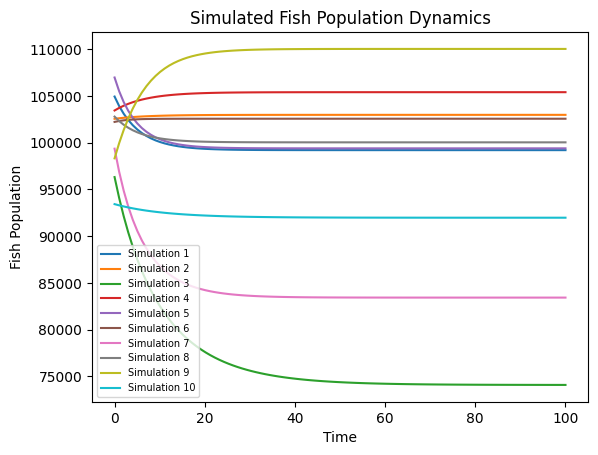

In [ ]:
#A custom Op to use the DE solver within PyMC
class FishPopulationOp(Op):
    #nodes used to construct the computational graph for the Op
    def make_node(self, B0, r, K, q):
        inputs = [pt.as_tensor_variable(var) for var in (B0, r, K, q)]
        outputs = [pt.vector(dtype='float64')]

        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        ## use the same DE solver to simulate the output population
        B0, r, K, q = inputs

        result = jitted_sol_op_jax(B0, r, K, q)
        outputs[0][0] = np.asarray(result, dtype='float64')


sol_op = FishPopulationOp()

# @jax_funcify.register(FishPopulationOp)
# def sol_op_jax_funcify(op, **kwargs):
#     return sol_op_jax

with pm.Model() as simulation_model:
    # Sample variables from normal distribution priors (the mean is the same as the values from previous example)
    # standard deviations - i chose them pretty arbitrarily
    B0 = pm.Normal("B0", mu=100000, sigma=10000)
    r = pm.Normal("r", mu=0.2, sigma=0.06)
    K = pm.Normal("K", mu=(100000/0.875), sigma=10000)
    q = pm.Normal("q", mu=0.025, sigma=0.01)

    ys = pm.Deterministic('ys', sol_op(B0, r, K, q))


with simulation_model:
    # Draw samples from the prior and simulate outputs
    simulations = pm.sample_prior_predictive(samples=10)


ys_simulations = simulations.prior["ys"]



## Plot the sim
time_points = jnp.linspace(0., t_end, num_points)


for i in range( ys_simulations.sizes['draw']):
    fish_over_time = ys_simulations.isel(draw=i).values.flatten()
    plt.plot(time_points, fish_over_time, label=f'Simulation {i+1}')

plt.xlabel('Time')
plt.ylabel('Fish Population')
plt.title('Simulated Fish Population Dynamics')
plt.legend(prop={'size': 7})
plt.show()

And this illustrates 10 simulations of  possible fish trajectories where each input variable is sampled from a normal distribution.


**Note 1:** This is meant to be a first stab at the fish sim. Of course in practice the plots would be much more volatile once we adapt the model to be more true to fish dynamics in real life. For instance, ecosystem degradation impacts fish population, the growth rate should be influenced by the mean age of fish,  etc...


**Note 2:** For our purposes, since the -qEB term would be a function of the AI boats, this term wouldn't be constant and would probably introduce a lot of instability in the population's steady state.





---



### Michael's continuation

I'm just going to tool around with PyMC's ODE tool:
https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_Lotka_Volterra_multiple_ways.html#pymc-ode-module


The DE that models the simulation is given by:

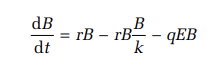

(see pg. 4 of link for description)

Where,

  B -  biomass of the fish (which I simply treated as # of fish)

  r - growth rate

  k - maximum capacity of fish the environment can hold

  q - number of fisherman boats

  E - effeciency of the fisherman boats

(for simplicity I lumped q & E into a single term)

In [ ]:
import arviz as az
from pytensor.compile.ops import as_op

In [ ]:
def rhs_pymcode(y, t, p) -> list:
    """
    Will be passed into DifferentialEquation
    p is our parameter tuple (r, k, qE)
    """
    B = y[0]
    return [p[0]*B - p[0]*B*B/p[1] - p[2]*B]

In [ ]:
ode_model = pm.ode.DifferentialEquation(
    rhs_pymcode, time_points, n_states=1, n_theta=3
)

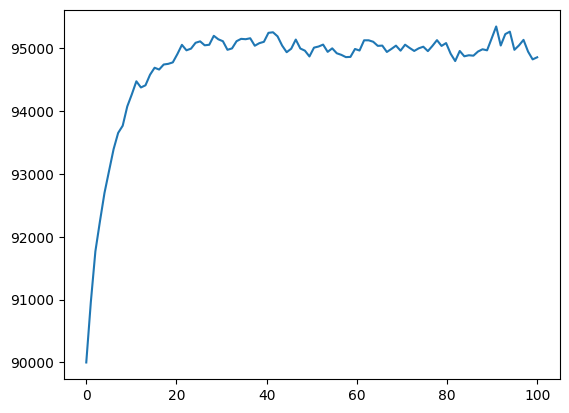

In [ ]:
# True params
# Deterministic example using variables mostly copied from the ref'd fish dynamics paper
B0 = 90000 # Initial biomass
r = 0.2  # Growth rate
k = 100000.0  # Max biomass
qE = 0.01  # Fishing effeciency
p = (r, k, qE)

# Generate sample data
observed = []
B = B0
for t in time_points:
    observed.append(B)
    B = max(0, B + rhs_pymcode([B], t, p)[0] + np.random.normal(0, 100))

plt.plot(time_points, observed)

In [ ]:
# pymc ODE expects vectors
_observed = [[o] for o in observed]

with pm.Model() as model:
    # Sample variables from normal distribution priors (the mean is the same as the values from previous example)
    # standard deviations - i chose them pretty arbitrarily
    B0 = pm.Normal("B0", mu=90000, sigma=2000)
    r = pm.Normal("r", mu=0.2, sigma=0.06)
    k = pm.Normal("k", mu=100000, sigma=10000)
    qE = pm.Normal("qE", mu=0.01, sigma=0.01)

    # ode_solution
    ode_solution = ode_model(y0=[B0], theta=[r, k, qE])

    # Not entirely sure...
    sigma = pm.HalfNormal("sigma", 10)

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution[0], sigma=sigma, observed=observed)

In [ ]:
#Joyee's note: this codeblock consistently errors with TypeError: unhashable type
#sampler = "NUTS PyMC ODE"
#tune = draws = 15
#with model:
#    trace_pymc_ode = pm.sample(15)

Justice's Continuation

In [ ]:
# # Define the DE
# def make_drift(r, K, q, E):
#     def drift(B):
#         dB_dt = r * B - B ** 2 * r / K - q * E * B
#         print(dB_dt)
#         return jnp.array([dB_dt])
#     return drift

# def fish_population_DE(t, B, args):
#     r, K, q, E = args
#     return make_drift(r, K, q, E)(B)

# def diffusion(t, x, args):
#     return jnp.array([1.])

# # Create the ODE term
# key = jax.random.PRNGKey(seed)
# ode_term = diffrax.ODETerm(fish_population_DE)
# bm = diffrax.UnsafeBrownianPath(shape=(1,), key=key)
# sde_term = diffrax.ControlTerm(diffusion, bm)

# terms = diffrax.MultiTerm(ode_term, sde_term)

# # Choose a diffrax solver to solve DE
# solver = diffrax.ItoMilstein()
# t_end = 100
# num_points = 100

# # Define the points in time where you want to save the solution
# saveat = diffrax.SaveAt(ts=jnp.linspace(0., t_end, num_points))
# # set the tolerated error between numerical estimation and true value
# # stepsize_controller = diffrax.PIDController(rtol=1e-5, atol=1e-5)
# stepsize_controller = diffrax.ConstantStepSize()

# # Wrap the ODE solver in a JAX function
# def sol_op_jax(B0, r, K, q, E):
#     sol = diffrax.diffeqsolve(
#         terms,
#         solver,
#         t0=0,
#         t1=t_end,
#         dt0=0.1,
#         y0=B0,
#         args=(r, K, q, E),
#         saveat=saveat,
#         stepsize_controller=stepsize_controller,
#         adjoint=diffrax.DirectAdjoint()
#     )

#     return sol.ys

# # don't actually know what this does, apparently improves computation performance
# jitted_sol_op_jax = jax.jit(sol_op_jax)

# # Deterministic example using variables mostly copied from the ref'd fish dynamics paper
# B0 = jnp.array([80000, 90000, 100000, 110000, 120000])  # Initial biomass
# r = 0.2  # Growth rate
# K = (100000/0.875)
# q = 0.025  # Fishing effeciency
# sigma_eps = 100  # std-dev of epsilon
# E = 0.5

# time_points = jnp.linspace(0., t_end, num_points)

# # Solve the ODE
# sol_ys = jitted_sol_op_jax(B0, r, K, q, E)

# #Plot the 5 sample simulations
# plt.plot(time_points, sol_ys, label='Deterministic Solution', color='black', linewidth=2)


# #A custom Op to use the DE solver within PyMC
# class FishPopulationOp(Op):
#     #nodes used to construct the computational graph for the Op
#     def make_node(self, B0, r, K, q):
#         inputs = [pt.as_tensor_variable(var) for var in (B0, r, K, q)]
#         outputs = [pt.vector(dtype='float64')]

#         return Apply(self, inputs, outputs)

#     def perform(self, node, inputs, outputs):
#         ## use the same DE solver to simulate the output population
#         B0, r, K, q = inputs

#         result = jitted_sol_op_jax(B0, r, K, q)
#         outputs[0][0] = np.asarray(result, dtype='float64')


# sol_op = FishPopulationOp()

# # @jax_funcify.register(FishPopulationOp)
# # def sol_op_jax_funcify(op, **kwargs):
# #     return sol_op_jax

# with pm.Model() as simulation_model:
#     # Sample variables from normal distribution priors (the mean is the same as the values from previous example)
#     # standard deviations - i chose them pretty arbitrarily
#     B0 = pm.Normal("B0", mu=100000, sigma=10000)
#     r = pm.Normal("r", mu=0.2, sigma=0.06)
#     K = pm.Normal("K", mu=(100000/0.875), sigma=10000)
#     q = pm.Normal("q", mu=0.025, sigma=0.01)

#     ys = pm.Deterministic('ys', sol_op(B0, r, K, q))


# with simulation_model:
#     # Draw samples from the prior and simulate outputs
#     simulations = pm.sample_prior_predictive(samples=10)


# ys_simulations = simulations.prior["ys"]



# ## Plot the sim
# time_points = jnp.linspace(0., t_end, num_points)


# for i in range( ys_simulations.sizes['draw']):
#     fish_over_time = ys_simulations.isel(draw=i).values.flatten()
#     plt.plot(time_points, fish_over_time, label=f'Simulation {i+1}')

# plt.xlabel('Time')
# plt.ylabel('Fish Population')
# plt.title('Simulated Fish Population Dynamics')
# plt.legend(prop={'size': 7})
# plt.show()

In [ ]:
import arviz as az
from pytensor.compile.ops import as_op

In [ ]:
# True params
# Deterministic example using variables mostly copied from the ref'd fish dynamics paper
B0 = 90000 # Initial biomass
r = 0.2  # Growth rate
k = 100000.0  # Max biomass
qE = 0.01  # Fishing effeciency
p = (r, k, qE)

In [ ]:
from collections import namedtuple
Params = namedtuple('Params', 'B, w, r, k, qE')

In [ ]:
class EulerMaruyamaDynamics:
  """
  Runs evolution of the fish population via the ODE
  """
  def __init__(self, t_end, num_points, D):
    self.time_points = jnp.linspace(0., t_end, num_points)
    self.dt = 1 / num_points
    self.D = D # diffusion coefficient

  def rhs_pymcode(self, Bs, rs, ks, qEs) -> list:
      """
      Will be passed into DifferentialEquation
      p is our parameter tuple (r, k, qE)
      """
      return rs*Bs - rs*Bs*Bs/ks - qEs*Bs

  def __call__(self, params: Params) -> list:
    # Generate sample data
    observed = []
    Bs = params.B
    observed.append(Bs)
    for t in self.time_points:
        rhs = self.rhs_pymcode(
                  Bs,
                  params.r,
                  params.k,
                  params.qE
        )
        if np.isnan(np.array(rhs)).any():
            import pdb; pdb.set_trace()
        Bs_step = Bs + rhs + np.random.normal(0, self.D * self.dt, Bs.shape)
        Bs = np.maximum(0, Bs_step)
        observed.append(Bs)
    return observed

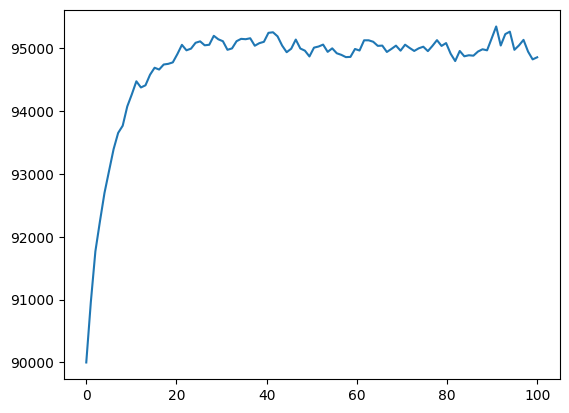

In [ ]:
plt.plot(time_points, observed)

In [ ]:
class RevenueModel:
    def __init__(self, P0, rho):
        self.P0 = P0
        self.rho = rho

    def __call__(self, B, qE):
        # TODO -- Some tracks of B hit zero
        #print(f"REVENUE -- {self.P0}, {B}, {self.rho}")
        PB = self.P0 * B ** self.rho
        return PB * qE * B

class CostModel:
    def __init__(self, C0, gamma):
        self.C0 = C0
        self.gamma = gamma

    def __call__(self, qE):
        # this doesn't seem correct since it doesn't depend on B
        return self.C0 * (1 - qE) ** self.gamma

class Policy:
    def __init__(self, revenue_model: RevenueModel, cost_model: CostModel):
        self.revenue_model = revenue_model
        self.cost_model = cost_model

    def sample(self, params: Params):
        #note: this models a profit-maximizing agent, and single agent, in particular!
        coef = -self.revenue_model.P0 / (self.cost_model.gamma * self.cost_model.C0)
        Bp = params.B ** (self.revenue_model.rho + 1)
        inv_gamma_power = 1 / (self.cost_model.gamma - 1)
        Es = 1 - (coef * Bp) ** inv_gamma_power
        Es = np.minimum(1, np.maximum(Es, 0.))
        return Es

class LossModel:
    def __call__(self, V_t, t, omega):
        return (-1 / (1 + omega) ** t) * np.minimum(V_t, 0)

class RiskModel:
    def __init__(self):
        self.ln_preference_prior = lambda x: jnp.mean(x, axis=0)

    def __call__(self, Lt, Vt):
        #this printing is important for evolving the preference model
        Gt = self.ln_preference_prior(Lt).mean() - entr(Lt)
        print(f"RISK: ", Gt)
        return Gt

In [ ]:
from copy import copy
class Model:
    def __init__(
      self,
      params,
      mc,
      dynamics,
      horizon,
      policy,
      revenue_model,
      cost_model,
      loss_model,
      risk_model,
      debug=False,
    ):
        self.params = params
        self.mc = mc
        self.dynamics = dynamics
        self.horizon = horizon
        self.policy = policy
        self.revenue_model = revenue_model
        self.cost_model = cost_model
        self.loss_model = loss_model
        self.risk_model = risk_model
        self.debug = debug

    def print(self, out: str, force: bool=False):
        if self.debug or force:
            print(out)

    def sample_policy(self, params: Params):
        Et = self.policy.sample(params)
        new_params = Params(
            B=params.B,
            w=params.w,
            r=params.r,
            k=params.k,
            qE=Et
        )
        return new_params

    def timestep(self, t: int, old_params: Params):
        params = self.sample_policy(old_params)
        observed = self.dynamics(params)
        Bt = observed[-1]
        Revt = self.revenue_model(Bt, params.qE)
        Ct = self.cost_model(params.qE)
        Vt = Revt - Ct
        Vt = jnp.nan_to_num(np.array(Vt), 0.)
        Lt = self.loss_model(Vt, t, params.w)

        params = Params(
            B=Bt,
            w=params.w,
            r=params.r,
            k=params.k,
            qE=params.qE
        )

        return Lt, Vt, Bt, params

    def plan(self, t_sim, params):
        Rt_sim = 0.
        for t_plan in range(self.horizon):
            t = t_sim + t_plan
            Lt, Vt, Bt, params = self.timestep(t, params)
            Gt = self.risk_model(Lt, Vt)
            Rt_sim -= Gt
        return Rt_sim

    @staticmethod
    def stack_params(params: list) -> Params:
        Bs = jnp.vstack([np.array(p.B) for p in params])
        ws = jnp.vstack([np.array(p.w) for p in params])
        rs = jnp.vstack([np.array(p.r) for p in params])
        ks = jnp.vstack([np.array(p.k) for p in params])
        qEs = jnp.vstack([np.array(p.qE) for p in params])
        return Params(Bs, ws, rs, ks, qEs)

    def get_sim_params(self):
        param_list = [copy(self.params) for _ in range(self.mc)]
        return Model.stack_params(param_list)

    def __call__(self):
        for t_sim in range(self.horizon):
            Lt_sim, Vt_sim, Bt_sim, self.params = self.timestep(t_sim, self.params)
            sim_params = self.get_sim_params()
            Rt_sim = self.plan(t_sim, sim_params)


In [ ]:
NUM_PARAM_BATCHES = 10

with pm.Model() as pm_model: #this is a pymc model and in particular the "with...as..." syntax means all assignments in this block are associated with this model's context!
    B0 = pm.Normal("B", mu=90000, sigma=2000)
    w = pm.LogNormal('w', mu=1., sigma=0.00001)
    r = pm.Normal("r", mu=0.2, sigma=0.06)
    k = pm.Normal("k", mu=100000, sigma=10000)
    qE = pm.Normal("qE", mu=0.01, sigma=0.01)

    samples = pm.sample_prior_predictive(samples=NUM_PARAM_BATCHES)

p = Params(**samples.prior)

In [ ]:
jnp.vstack([p.B.to_numpy(), p.B.to_numpy()]).shape

(2, 10)

In [ ]:
wt_end = 100
num_points = 20
D = 1000
mc = 10
horizon = 20
P0 = 1
rho = -0.9
C0 = 1
gamma = -0.9

dynamics = EulerMaruyamaDynamics(t_end, num_points, D)
revenue_model = RevenueModel(P0=P0, rho=rho)
cost_model = CostModel(C0=C0, gamma=gamma)
policy = Policy(revenue_model, cost_model)
loss_model = LossModel()
risk_model = RiskModel()

model = Model(
    p,
    mc,
    dynamics,
    horizon,
    policy,
    revenue_model,
    cost_model,
    loss_model,
    risk_model,
    debug=True,
)

model()

<ipython-input-24-b1c36f69bb1e>:9: RuntimeWarning: divide by zero encountered in power
  PB = self.P0 * B ** self.rho
<ipython-input-24-b1c36f69bb1e>:10: RuntimeWarning: invalid value encountered in multiply
  return PB * qE * B
/usr/local/lib/python3.10/dist-packages/scipy/stats/_entropy.py:360: RuntimeWarning: divide by zero encountered in log
  term1 = 1/(n-m) * np.sum(np.log((n+1)/m * difference), axis=-1)
<ipython-input-24-b1c36f69bb1e>:31: RuntimeWarning: divide by zero encountered in power
  Es = 1 - (coef * Bp) ** inv_gamma_power


RISK:  [       inf 2.57840351 1.26067581        inf        inf 1.7073086
        inf 3.19683356        inf 2.49021339]
RISK:  [3.0019651  3.57818792 2.63297225 1.98292615        inf 2.82748819
 2.61143581 2.97112998        inf        inf]
RISK:  [3.18011869        inf 3.81130627 3.15899985 3.58029819 3.95648493
 4.635494   2.95555151        inf        inf]
RISK:  [4.86476258 3.97278967 4.11257494 5.977295   4.57114719 5.13651627
 4.37480561 5.07218589 4.10946318 4.610354  ]
RISK:  [6.5295905  5.76099112 6.53123737 6.97423005 6.61267142 6.97918675
 6.89271722 6.81691018 6.44820818 6.08031923]
RISK:  [8.06620243 6.81483787 7.61534316 6.8273285  7.7355445  8.65122964
        inf 7.55707554 8.28652125 7.70652123]
RISK:  [9.52970102 8.97612631 8.43966916 7.89519345 8.73977301 9.06336084
        inf 9.03371867 8.81752897 9.11611381]
RISK:  [ 9.48334048  9.73525836  9.68472604 10.36146155 10.60780135  9.38510017
         inf 10.75699868  9.37074144  9.85968323]
RISK:  [11.52607033 11.61428181

Joyee's contribution: the effects of evolving the preference model
Here we assume that the world model parameters are known certainly
but that the mean and standard deviation parameters for omega (the stakeholder preference param)
itself changes over episodes. This models stakeholders changing their minds.
We need w to change at each timestep, which requires a new notion of w.

What we need to do is insert code at each episode that updates mu and sigma according to an evolutionary schedule, then uses that to construct a new distribution for which to pick/sample w, then samples from that distribution and passes that sample into LossModel [which from then on can pass its results to the risk model and downstream without any needed changes].

In [ ]:
#And where does each episode update? At each timestep.
class EvolvedPreferenceModel(Model):
     #introduce notion of starter mu and starter sigma
     def __init__(
      self,
      params,
      mc,
      dynamics,
      horizon,
      policy,
      revenue_model,
      cost_model,
      loss_model,
      risk_model,
      debug=False,
      mu = 0.,
      sigma = 1.,
      mu_updater = lambda x: x,
      sigma_updater = lambda x: x
    ):
      Model.__init__(
      self,
      params,
      mc,
      dynamics,
      horizon,
      policy,
      revenue_model,
      cost_model,
      loss_model,
      risk_model,
      debug=False,
     )
      self.mu = mu #for some initial mu
      self.sigma = sigma #for some initial sigma
      self.mu_updater = mu_updater #a lambda function that updates mu, here initialized to the degenerate case
      self.sigma_updater = sigma_updater #a lambda function that updates sigma, here initialized to degenerate case

     def timestep(self, t: int, old_params: Params):
        params = self.sample_policy(old_params)
        observed = self.dynamics(params)
        Bt = observed[-1]
        Revt = self.revenue_model(Bt, params.qE)
        Ct = self.cost_model(params.qE)
        Vt = Revt - Ct
        Vt = jnp.nan_to_num(np.array(Vt), 0.)
        #this is my addition
        self.mu = self.mu_updater(self.mu)
        self.sigma = self.sigma_updater(self.sigma)
        #params.w = np.exp(self.mu)*jax.random.lognormal(sigma = self.sigma) #this is because lognormal(mu, sigma) = exp(mu)lognormal(0, sigma) which jax supports
        with pm_model:
          w = pm.LogNormal('w', mu = self.mu, sigma = self.sigma)
          samples = pm.sample_prior_predictive(samples=NUM_PARAM_BATCHES)
        p = Params(**samples.prior)
        params.w = p.w
        #end of my addition
        Lt = self.loss_model(Vt, t, params.w)

        params = Params(
            B=Bt,
            w=params.w,
            r=params.r,
            k=params.k,
            qE=params.qE
        )

        return Lt, Vt, Bt, params

Now that we seemingly have some code, let's actually run it in the service of solving some problems. Our first place to explore: we might want to test the intuitive notion that short-sighted corporate decision processes lead to ecological and ultimately economic ruin.

By the definition of omega, the discount factor, we can express that hypothesis as "distributions of omega such that omega < 0.05 is unlikely" (which correspond to stakeholder shortsightedness) lead to all but the first few episodes being discounted away (because of short-sightedness).

We can translate this even further into the technical language, as the hypothesis "For omega distributions with P(omega < 0.05) close to 0, we should see finite values of risk (given the unconstrained profit maximizing policy)," because each episode's loss is actually finitely bounded.

In [ ]:
#Let's test out the hypothesis for omega hyperparameters mean = 1 and standard deviation varying anywhere from 0.2 to 2.
#From wolframalpha, one can plot pdf curves to see that as the standard deviation decreases, the closer the omega distribution
#will fit the P(omega<0.05) -> 0 ideal, so we would expect the risk to become more and more finite.
mu = 1.
for experimental_st_dev in np.arange(0.2, 2.0, 0.2):
  #we run a full loop of testing and graphing on that range.
  experimental_model = EvolvedPreferenceModel(
    p,
    mc,
    dynamics,
    horizon,
    policy,
    revenue_model,
    cost_model,
    loss_model,
    risk_model,
    debug=True,
    mu = mu,
    sigma = experimental_st_dev,
    mu_updater = lambda x: x, #we're not doing the second bullet point just yet
    sigma_updater = lambda x: x
  )
  experimental_model()
  #and then produce graphs after recording data